# SeqGAN

Цели:

- Разобраться с основными архитектурными решениями и алгоритмом обучения SeqGAN
- Реализация SeqGAN для задачи посимвольной генерации текстов

Содержание:

* [Введение](#intro)
* [Загрузка данных](#load_data)
* [Алгоритм обучения](#algorithm)
  * [Генератор](#generator)
  * [Дискриминатор](#discriminator)
  * [Предобучение генератора (MLE)](#gen_pretrain)
  * [Предобучение дискриминатора](#disc_pretrain)
  * [Обучение в состязательном режиме](#adversarial_train)

Ссылки:

* [SeqGAN: Sequence Generative Adversarial Nets with Policy Gradient. Статья на ArXiv](https://arxiv.org/pdf/1609.05473v6.pdf)
* [Deep Reinforcement Learning: Pong from Pixels](http://karpathy.github.io/2016/05/31/rl/)
* [Реализация на pytorch](https://github.com/X-czh/SeqGAN-PyTorch/tree/master)
* [Адаптированная реализация из репозитория TextGAN-PyTorch](https://github.com/sswt/dive2gai/blob/main/unit4/seqgan_textgan.py)


<a name="load_data"></a>
## Загрузка данных

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from time import time
from collections import namedtuple
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget -q https://huggingface.co/datasets/sswt/arxiv_sample_50K/resolve/main/title_summary_ascii.txt.tar.gz -O data.tar.gz && tar -xzf data.tar.gz

In [3]:
max_len = 32  # default - 128, 32 for debug
with open('title_summary_ascii.txt') as fp:
    lines = [line[:max_len] for line in fp.readlines()]

In [4]:
vocab = {c: i for i, c in enumerate(sorted(set([c for l in lines for c in l])))}
inv_vocab = {i: c for c, i in vocab.items()}
vocab_size = len(vocab)
len(vocab)

67

In [5]:
lines[:3]

[' On Finitely Generated Models of',
 ' Generalized modeling of ecologi',
 ' Generating Subsurface Earth Mod']

In [6]:
''.join(vocab)

" ',.0123456789;ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

In [7]:
lines, val_lines = train_test_split(lines, test_size=1024, random_state=42)
len(lines), len(val_lines)

(48976, 1024)

<a name="intro"></a>
## Введение

В классических GAN'ах генератор сэмплирует случайный вектор $z$, а затем выполняет детерминированное преобразование в соответствии с его весами. Далее сгенерированный сэмпл вместе с настоящим пропускается через дискриминатор и градиент функции потерь дискриминатора используется, чтобы немного изменить генерируемое генератором значение и оно стало чуть более правдоподобным. Но для дискретных токенов нельзя "немного" изменить значение. То есть для изображения можно изменить пиксель на 0.0001, а для слова "слово + 0.0001" непонятно чем является, даже если делать это в пространстве эмбеддингов.

Ещё один недостаток заключается в том, что GAN оценивает функцию потерь только для последовательности целиком, то есть после того, как она полностью сгенерирована, а сделать это в процессе генерации для GAN не так просто.

В SeqGAN процесс генерации рассматривается как процесс последовательного принятия решений, как в обучении с подкреплением (reinforcement learning). Основная идея обучения с подкреплением состоит в том, что агент находясь в каком-то состоянии взаимодействует с окружающей средой, предпринимая действия и переходя в новые состояния. Окружающая среда его поощряет за эти действия, а агент продолжает их предпринимать, пытаясь максимизировать свою "награду".

<img src="https://yanpuli.github.io/images/rl1.png" alt="SeqGAN" width="75%" />

В нашей постановке задачи:

* состояние - уже сгенерированная часть последовательности
* действие - выбор следующего токена

Вопрос - как определить вознаграждение? Для этого используется дискриминатор, а точнее его оценка вероятности принадлежности сгенерированной последовательности к реальной.

У нас есть генератор $G_\theta$ и дискриминатор $D_ϕ$. $D_ϕ(Y_{1:T})$ - вероятность того, что последовательность $Y_{1:T}$ - реальная. $G$ обучается с помощью алгоритма policy gradient, где финальное значение вознаграждения за всю сгенерированную последовательность целиком выдаётся $D$ и передаётся обратно к промежуточным состояниям (предыдущим токенам) с помощью поиска по методу Монте Карло MC.

<img src="https://raw.githubusercontent.com/sswt/dive2gai/main/.github/images/w4/seqgan_arch.png" alt="SeqGAN" width="75%" />


<a name="algorithm"></a>
## Алгоритм обучения

### Градиент по стратегиям (policy gradient)

Генератор $G_\theta$ - параметрически заданная политика или стратегия в терминах RL (policy).

У нас нет немедленной награды на каждом шаге, в этом случае целевая функция генератора $G_θ(y_t|Y_{1:t−1})$ - сгенерировать последовательность от начального состояния $s_0$ для того, чтобы максимизировать мат. ожидание конечного вознаграждения:

$$J(θ)=\mathbb{E}[R_T|s_0,θ] = \sum_{y_1∈Y}G_θ(y_1|s_0)·Q^{G_θ}_{D_φ} (s_0,y_1),$$ где ${R_T}$ - вознаграждение для последовательности целиком, $Q^{G_θ}_{D_φ}(s, a)$ - action-value функция для последовательности, то есть ожидаемое накопленное вознаграждение, начиная с состояния $s$, предпринимаемая действие $a$, и затем следуя стратегии $G_θ$.

Как оценить action-value функцию? В данной работе авторы использовали алгоритм REINFORCE и в качестве вознаграждения используется оценка вероятности, что последовательность настоящая $D_φ(Y_{1:T})$:

$$Q^{G_θ}_{D_φ}(a=y_T ,s=Y_{1:T-1}) = D_φ(Y_{1:T})$$

Алгоритм REINFORCE основывается на принципе усиления политики: агент увеличивает вероятность действий, которые приводят к высоким наградам, и уменьшает вероятность действий, которые приводят к низким наградам. Этот процесс повторяется на протяжении обучения, и агент старается научиться выбирать оптимальные действия, максимизирующие суммарную награду.

Но вознаграждение доступно только для законченной последовательности. И здесь мы не просто на каждом шаге оцениваем удачность текущего действия, но ещё и беспокоимся о конечном результате. Это похоже на игры в шахматы или Го, когда мы можем поступиться текущими интересами для победы во всей партии.

Для оценки вознаграждения на промежуточных шагах, применяется метод Монте-Карло. Находясь в состоянии $t$, мы в с помощью генератора $G_β$ сэмплируем последние $T-t$ токенов последовательности $Y_{1:T}$ и через дискриминатор оцениваем вероятность того, что она реальная. Повторяем процедуру $N$ раз и усредняем оценку полученной вероятности:

$$Q^{G_θ}_{D_φ}(s = Y_{1:t−1}, a = y_t) = \begin{cases}
\frac{1}{N} \sum^N_{n=1} D_φ(Y^n_{1:T}), Y^n_{1:T} ∈ MC^{G_β}(Y_{1:t};N) \text{ for }t < T,\\
Dφ(Y_{1:t})\text{ for }t=T\end{cases}\tag{4}$$

где $MC^{G_β}(Y_{1:t};N)$ - результат Монте-Карло симуляции для промежуточных шагов, где мы генерируем N последовательностей начиная с текущего состояния $s'=Y_{1:t}$.

Благодаря тому, что у нас в качестве вознаграждения используется $D_φ$, мы можем его динамически обновлять для последующего улучшения генератора. То есть только у нас начинают генерироваться похожие на настоящие последовательности, мы должны переобучить дискриминатор (с помощью обычной кросс-энтропии):

$$\min_φ (−\mathbb{E}_{Y ∼p_{data}} [log D_φ(Y)] − \mathbb{E}_{Y∼G_θ}[log(1 − D_φ(Y ))]) \tag{5}$$

После получения новой модели дискриминатора, мы можем обновить генератор.В методе градиента по стратегиям (policy gradient) оптимизируется параметризованная политика для непосредственного увеличения награды на длительном промежутке времени.  Градиент целевой функции $J(θ)$ по параметрам генератора $θ$ может быть выражен как:

$$∇_θ J(θ) = \sum_{t+1}^T \mathbb{E}_{y_t∼G_θ (y_t|Y_{1:t−1})}[∇_θ log G_θ (y_t|Y_{1:t−1}) · Q_{G_θ}^{D_φ}(Y_{1:t−1}, y_t)]$$,
где $Y_{1:t−1}$ - промежуточная последовательность из $G_θ$.

Поскольку мат. ожидание $\mathbb{E}[·]$ может быть приблизительно вычислено с помощью сэмплирования, то параметры генератора могут быть обновлены например с помощью SGD:
$$θ ← θ + α_h∇_θ J(θ), \tag{8}$$

где $α_h ∈ R^+$ - learning rate на h-м шаге.

Итого весь алгоритм выглядит следующим образом:

<img src="https://raw.githubusercontent.com/sswt/dive2gai/main/.github/images/w4/seqgan_algorithm.png" alt="SeqGAN algorithm" width="50%" />

В начале генератор $G_θ$ предобучается с помощью MLE. Затем дискриминатор $D_ϕ$ предобучается отличать сгенерированные $G_θ$ последовательности от реальных. По опыту авторов обучающий сигнал от предобученного $D_ϕ$ позволяет обучать генератор более эффективно.

Затем $G_θ$ и $D_ϕ$ обучаются последовательно. Как только генератор прогрессирует за счёт обучения на g-шагах, дискриминатор тоже надо дообучить на улучшенных сгенерированных последовательностях. Для баланса классов число генерируемых последовательностей совпадает с числом реальных.


<a name="generator"></a>
### Генератор

Генератор - обычная RNN, здесь используется LSTM, но это может быть GRU или трансформер.

In [8]:
class DataIterator:
    def __init__(self, texts, vocab, batch_size=32, max_len=256):
        self.texts = texts
        self.vocab = vocab
        self.max_len = max_len
        self.batch_size = batch_size
        self.ixs = np.arange(len(texts))
        self.pos = 0
        self.reset()

    def __len__(self):
        return len(self.texts) // self.batch_size

    def __iter__(self):
        return self

    def __next__(self):
        if len(self)*self.batch_size - self.pos < self.batch_size:
           raise StopIteration
        indices = self.ixs[self.pos:self.pos + self.batch_size]
        sequences = torch.stack([self.to_tensor(self.texts[i]) for i in indices])
        self.pos += self.batch_size
        return sequences[:, :-1], sequences[:, 1:]

    def reset(self):
        self.pos = 0
        np.random.shuffle(self.ixs)

    def to_tensor(self, line):
        t = torch.LongTensor([self.vocab[line[li]] for li in range(len(line[:self.max_len]))])
        if len(line) < self.max_len:
            t = nn.ConstantPad1d((0, self.max_len - len(line)), 0)(t)
        return t

In [9]:
class Generator(nn.Module):
    """ Generator """

    def __init__(self, vocab_size, embedding_dim, hidden_dim, use_cuda):
        super(Generator, self).__init__()
        self.hidden_dim = hidden_dim
        self.use_cuda = use_cuda
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.init_params()

    def forward(self, x):
        """
        Embeds input and applies LSTM on the input sequence.

        Inputs: x
            - x: (batch_size, seq_len), sequence of tokens generated by generator
        Outputs: out
            - out: (batch_size * seq_len, vocab_size), lstm output prediction
        """
        self.lstm.flatten_parameters()
        h0, c0 = self.init_hidden(x.size(0))
        emb = self.embed(x) # batch_size * seq_len * emb_dim
        out, _ = self.lstm(emb, (h0, c0)) # out: batch_size * seq_len * hidden_dim
        out = self.log_softmax(self.fc(out.contiguous().view(-1, self.hidden_dim))) # (batch_size*seq_len) * vocab_size
        return out

    def step(self, x, h, c):
        """
        Embeds input and applies LSTM one token at a time (seq_len = 1).

        Inputs: x, h, c
            - x: (batch_size, 1), sequence of tokens generated by generator
            - h: (1, batch_size, hidden_dim), lstm hidden state
            - c: (1, batch_size, hidden_dim), lstm cell state
        Outputs: out, h, c
            - out: (batch_size, vocab_size), lstm output prediction
            - h: (1, batch_size, hidden_dim), lstm hidden state
            - c: (1, batch_size, hidden_dim), lstm cell state
        """
        self.lstm.flatten_parameters()
        emb = self.embed(x) # batch_size * 1 * emb_dim
        out, (h, c) = self.lstm(emb, (h, c)) # out: batch_size * 1 * hidden_dim
        out = self.log_softmax(self.fc(out.contiguous().view(-1, self.hidden_dim))) # batch_size * vocab_size
        return out, h, c

    def init_hidden(self, batch_size):
        h = torch.zeros(1, batch_size, self.hidden_dim)
        c = torch.zeros(1, batch_size, self.hidden_dim)
        if self.use_cuda:
            h, c = h.cuda(), c.cuda()
        return h, c

    def init_params(self):
        for param in self.parameters():
            param.data.uniform_(-0.05, 0.05)

    def sample(self, batch_size, seq_len, x=None):
        """
        Samples the network and returns a batch of samples of length seq_len.

        Outputs: out
            - out: (batch_size * seq_len)
        """
        # TODO: Fix generation to be one pass instead of step-by-step loop
        # TODO: Add stop iteration on EOS token
        samples = []
        if x is None:
            h, c = self.init_hidden(batch_size)
            x = torch.zeros(batch_size, 1, dtype=torch.int64)
            if self.use_cuda:
                x = x.cuda()
            for _ in range(seq_len):
                out, h, c = self.step(x, h, c)
                prob = torch.exp(out)
                x = torch.multinomial(prob, 1)
                samples.append(x)
        else:
            h, c = self.init_hidden(x.size(0))
            given_len = x.size(1)
            lis = x.chunk(x.size(1), dim=1)
            for i in range(given_len):
                out, h, c = self.step(lis[i], h, c)
                samples.append(lis[i])
            prob = torch.exp(out)
            x = torch.multinomial(prob, 1)
            for _ in range(given_len, seq_len):
                samples.append(x)
                out, h, c = self.step(x, h, c)
                prob = torch.exp(out)
                x = torch.multinomial(prob, 1)
        out = torch.cat(samples, dim=1) # along the batch_size dimension
        return out

<a name="discriminator"></a>
### Дискриминатор

В качестве дискриминатора используется свёрточная сеть, которая предсказывает для последовательности целиком - реальная она или сгенерированная.

* для токенов строятся k-мерные эмбеддинги
* применяется набор свёрточных фильтров с различной шириной окна
* max pooling поверх которого применяется highway-архитектура
* dropout
* полносвязный слой с выходом на два класса

Highway-архитектура - когда в глубоких полносвязных сетях добавляются skip connections через несколько слоёв, которые называются information highways. При этом информация пропускается через фильтры с сигмоидой (привет LSTM). Выход слоя считается по формуле:

$y = H(x, W_H) · T(x, W_T) + x · C(x, W_C)$,

где $ H(x, W_H)$ - привычный линейный слой с какой-то нелинейной функцией активации $H$, $T(x, W_T)$ - transform gate с сигмоидой, $C(x,W_C)$ - carry gate, $С = 1 - T$.

Это позволяет облегчить протекание градиентов.

In [10]:
import math
import random

class DisDataIter:
    def __init__(self, real_data, fake_data, batch_size, vocab, max_len):
        super(DisDataIter, self).__init__()
        assert len(real_data) == len(fake_data)
        self.batch_size = batch_size
        self.data = real_data + fake_data
        self.labels = [1 for _ in range(len(real_data))] + [0 for _ in range(len(fake_data))]
        self.pairs = list(zip(self.data, self.labels))
        self.data_num = len(self.pairs)
        self.indices = range(self.data_num)
        self.num_batches = math.ceil(self.data_num / self.batch_size)
        self.vocab = vocab
        self.max_len = max_len
        self.idx = 0
        self.reset()

    def __len__(self):
        return self.num_batches

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def reset(self):
        self.idx = 0
        random.shuffle(self.pairs)

    def next(self):
        if self.idx >= self.data_num:
            raise StopIteration
        index = self.indices[self.idx : self.idx + self.batch_size]
        pairs = [self.pairs[i] for i in index]
        data = [self.to_tensor(p[0]) for p in pairs]
        label = [torch.tensor(p[1]) for p in pairs]
        data = torch.stack(data)
        label = torch.stack(label)
        self.idx += self.batch_size
        return data, label

    def to_tensor(self, line):
        t = torch.LongTensor([self.vocab[line[li]] for li in range(len(line[:self.max_len]))])
        if len(line) < self.max_len:
            t = nn.ConstantPad1d((0, self.max_len - len(line)), 0)(t)
        return t

In [11]:
class Discriminator(nn.Module):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    Highway architecture based on the pooled feature maps is added. Dropout is adopted.
    """

    def __init__(self, vocab_size, embedding_dim, filter_sizes, num_filters, dropout_prob, num_classes=2):
        super(Discriminator, self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_f, (f_size, embedding_dim)) for f_size, num_f in zip(filter_sizes, num_filters)
        ])
        self.highway = nn.Linear(sum(num_filters), sum(num_filters))
        self.dropout = nn.Dropout(p = dropout_prob)
        self.fc = nn.Linear(sum(num_filters), num_classes)

    def forward(self, x):
        """
        Inputs: x
            - x: (batch_size, seq_len)
        Outputs: out
            - out: (batch_size, num_classes)
        """
        emb = self.embed(x).unsqueeze(1) # batch_size, 1 * seq_len * emb_dim
        convs = [F.relu(conv(emb)).squeeze(3) for conv in self.convs] # [batch_size * num_filter * seq_len]
        pools = [F.max_pool1d(conv, conv.size(2)).squeeze(2) for conv in convs] # [batch_size * num_filter]
        out = torch.cat(pools, 1)  # batch_size * sum(num_filters)
        highway = self.highway(out)
        transform = F.sigmoid(highway)
        out = transform * F.relu(highway) + (1. - transform) * out # sets C = 1 - T
        out = F.log_softmax(self.fc(self.dropout(out)), dim=1) # batch * num_classes
        return out

<a name="gen_pretrain"></a>
### Предобучение генератора с помощью MLE

Уже знакомое "привычное" обучение RNN с предыдущего занятия

In [12]:
def train_generator_MLE(gen, data_iter, criterion, optimizer, epochs, losses, cuda):
    """
    Train generator with MLE
    """
    for epoch in range(epochs):
        total_loss = 0.
        for data, target in data_iter:
            if cuda:
                data, target = data.cuda(), target.cuda()
            target = target.contiguous().view(-1)
            output = gen(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        data_iter.reset()
        avg_loss = total_loss / len(data_iter)
        print(f"Epoch {epoch}, train loss: {avg_loss:.5f}", end=', ')
        losses.append(avg_loss)

def generate_samples(model, batch_size, generated_num, inv_vocab, g_seq_len=20):
    samples = []
    for _ in range(int(generated_num / batch_size)):
        sample = model.sample(batch_size, g_seq_len).cpu().data.numpy().tolist()
        samples.extend(sample)
    return [''.join([inv_vocab[s] for s in sample]) for sample in samples]

def eval_generator(model, data_iter, criterion, cuda):
    """
    Evaluate generator with NLL
    """
    total_loss = 0.
    with torch.no_grad():
        for data, target in data_iter:
            if cuda:
                data, target = data.cuda(), target.cuda()
            target = target.contiguous().view(-1)
            pred = model(data)
            loss = criterion(pred, target)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_iter)
    return avg_loss

In [13]:
args = {
    'hpc': False,  # 'set to hpc mode'
    'data_path': './seq_gan/', # data path to save files (default: ./seq_gan/)
    'rounds': 15,  # rounds of adversarial training (default: 150)
    'g_pretrain_steps': 120,  #! steps of pre-training of generators (default: 120)
    'd_pretrain_steps': 10,  #! steps of pre-training of discriminators (default: 50)
    'g_steps': 1,  # steps of generator updates in one round of adverarial training (default: 1)
    'd_steps': 3,  #! steps of discriminator updates in one round of adverarial training (default: 3)
    'gk_epochs': 1,  # epochs of generator updates in one step of generate update (default: 1)
    'dk_epochs': 2,  #! epochs of discriminator updates in one step of discriminator update (default: 3)
    'update_rate': 0.8,  # update rate of roll-out model (default: 0.8)
    'n_rollout': 16,  #! number of roll-out (default: 16)
    # 'vocab_size': 10,  # vocabulary size (default: 10)
    'batch_size': 64,  # batch size (default: 64)
    'n_samples': 4096,  # number of samples generated per time (default: 6400, speedup: 320)
    'gen_lr': 1e-3,  # learning rate of generator optimizer (default: 1e-3)
    'dis_lr': 1e-3,  # learning rate of discriminator optimizer (default: 1e-3)
    'no_cuda': False,  # disables CUDA training
    'seed': 1,  # random seed (default: 1)
}
args = namedtuple('Struct', args)(**args)

In [14]:
cuda = torch.cuda.is_available()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cuda

True

In [15]:
real_lines = lines[:args.n_samples]

In [16]:
data_iter = DataIterator(real_lines, vocab, max_len=max_len)

In [17]:
# Generator Parameters
g_embed_dim = 64
g_hidden_dim = 64
generator = Generator(vocab_size, g_embed_dim, g_hidden_dim, cuda).to(device)
nll_loss = nn.NLLLoss()
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=args.gen_lr)

In [18]:
gen_pretrain_train_loss = []
gen_pretrain_eval_loss = []
for i in range(args.g_pretrain_steps):
    print("G-Step {}".format(i), end=' - ')
    train_generator_MLE(generator, data_iter, nll_loss, gen_optimizer, args.gk_epochs, gen_pretrain_train_loss, cuda)
    eval_iter = DataIterator(val_lines, vocab, max_len=max_len)
    gen_loss = eval_generator(generator, eval_iter, nll_loss, cuda)
    gen_pretrain_eval_loss.append(gen_loss)
    print("eval loss: {:.5f}".format(gen_loss))
    # print(generate_samples(generator, args.batch_size, args.batch_size, inv_vocab, g_seq_len=max_len)[0])
gen_lines = generate_samples(generator, args.batch_size, args.n_samples, inv_vocab, g_seq_len=max_len)

G-Step 0 - Epoch 0, train loss: 3.41654, eval loss: 3.21610
G-Step 1 - Epoch 0, train loss: 3.18600, eval loss: 3.12905
G-Step 2 - Epoch 0, train loss: 2.97498, eval loss: 2.84546
G-Step 3 - Epoch 0, train loss: 2.75556, eval loss: 2.71764
G-Step 4 - Epoch 0, train loss: 2.65268, eval loss: 2.62901
G-Step 5 - Epoch 0, train loss: 2.56319, eval loss: 2.54278
G-Step 6 - Epoch 0, train loss: 2.48222, eval loss: 2.46831
G-Step 7 - Epoch 0, train loss: 2.41215, eval loss: 2.40430
G-Step 8 - Epoch 0, train loss: 2.34939, eval loss: 2.34375
G-Step 9 - Epoch 0, train loss: 2.28994, eval loss: 2.28748
G-Step 10 - Epoch 0, train loss: 2.23468, eval loss: 2.23446
G-Step 11 - Epoch 0, train loss: 2.18342, eval loss: 2.18765
G-Step 12 - Epoch 0, train loss: 2.13586, eval loss: 2.14261
G-Step 13 - Epoch 0, train loss: 2.09305, eval loss: 2.10134
G-Step 14 - Epoch 0, train loss: 2.05492, eval loss: 2.06718
G-Step 15 - Epoch 0, train loss: 2.02056, eval loss: 2.03612
G-Step 16 - Epoch 0, train loss: 1

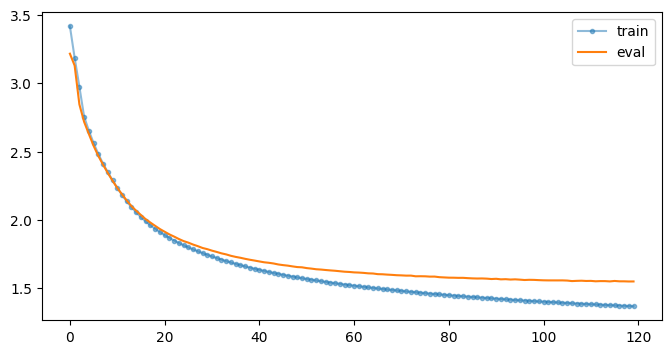

In [19]:
plt.rcParams['figure.figsize'] = (8, 4)
plt.plot(gen_pretrain_train_loss, marker='.', alpha=.5)
plt.plot(gen_pretrain_eval_loss)
plt.legend(['train', 'eval']);

In [20]:
len(gen_lines)

4096

In [21]:
gen_lines[:3]

['Code KRM An Effectivelice anterr',
 'Foulding a Model Trassical Price',
 'Dy Closolene Generalized Linear ']

<a name="disc_pretrain"></a>
### Предобучение дискриминатора

Бинарный классификатор - сгенерированная последовательность или реальная

In [22]:
def train_discriminator(dis, data_iter, criterion, optimizer, epochs,
        dis_adversarial_train_loss, dis_adversarial_train_acc, cuda):
    """
    Train discriminator
    """
    for epoch in range(epochs):
        correct = 0
        total_loss = 0.
        for data, target in data_iter:
            if cuda:
                data, target = data.cuda(), target.cuda()
            target = target.contiguous().view(-1)
            output = dis(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.data).cpu().sum()
            loss = criterion(output, target)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        data_iter.reset()
        avg_loss = total_loss / len(data_iter)
        acc = correct.item() / data_iter.data_num
        print("Epoch {}, train loss: {:.5f}, train acc: {:.3f}".format(epoch, avg_loss, acc))
        dis_adversarial_train_loss.append(avg_loss)
        dis_adversarial_train_acc.append(acc)

def eval_discriminator(model, data_iter, criterion, cuda):
    """
    Evaluate discriminator, dropout is enabled
    """
    correct = 0
    total_loss = 0.
    with torch.no_grad():
        for data, target in data_iter:
            if cuda:
                data, target = data.cuda(), target.cuda()
            target = target.contiguous().view(-1)
            output = model(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.data).cpu().sum()
            loss = criterion(output, target)
            total_loss += loss.item()
        data_iter.reset()
    avg_loss = total_loss / len(data_iter)
    acc = correct.item() / data_iter.data_num
    return avg_loss, acc

In [23]:
disc_data_iter = DisDataIter(real_lines, gen_lines, args.batch_size, vocab, max_len)

In [24]:
d_embed_dim = 64
d_filter_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
d_num_filters = [100, 200, 200, 200, 200, 100, 100, 100, 100, 100, 160, 160]
d_dropout_prob = 0.2
discriminator = Discriminator(vocab_size, d_embed_dim, d_filter_sizes, d_num_filters, d_dropout_prob).to(device)
dis_optimizer = torch.optim.SGD(params=discriminator.parameters(), lr=args.dis_lr)

In [25]:
gen_lines = generate_samples(generator, args.batch_size, args.n_samples, inv_vocab, g_seq_len=max_len)

In [26]:
dis_adversarial_train_loss = []
dis_adversarial_train_acc = []
dis_pretrain_eval_loss = []
dis_pretrain_eval_acc = []

In [27]:
gen_val_lines = generate_samples(generator, args.batch_size, len(val_lines), inv_vocab, g_seq_len=max_len)
eval_iter = DisDataIter(val_lines, gen_val_lines, args.batch_size, vocab, max_len)
for i in range(args.d_pretrain_steps):
    t0 = time()
    print("D-Step {}".format(i))
    train_discriminator(discriminator, disc_data_iter, nll_loss,
        dis_optimizer, args.dk_epochs, dis_adversarial_train_loss, dis_adversarial_train_acc, cuda)
    dis_loss, dis_acc = eval_discriminator(discriminator, eval_iter, nll_loss, cuda)
    dis_pretrain_eval_loss.append(dis_loss)
    dis_pretrain_eval_acc.append(dis_acc)
    print("eval loss: {:.5f}, eval acc: {:.3f}, elapsed: {:.1f}s".format(dis_loss, dis_acc, time() - t0))

D-Step 0
Epoch 0, train loss: 0.70156, train acc: 0.517
Epoch 1, train loss: 0.70404, train acc: 0.513
eval loss: 0.70281, eval acc: 0.521, elapsed: 7.3s
D-Step 1
Epoch 0, train loss: 0.70307, train acc: 0.513
Epoch 1, train loss: 0.69686, train acc: 0.530
eval loss: 0.69294, eval acc: 0.552, elapsed: 3.7s
D-Step 2
Epoch 0, train loss: 0.69483, train acc: 0.536
Epoch 1, train loss: 0.69318, train acc: 0.536
eval loss: 0.68682, eval acc: 0.556, elapsed: 3.6s
D-Step 3
Epoch 0, train loss: 0.68932, train acc: 0.548
Epoch 1, train loss: 0.68713, train acc: 0.558
eval loss: 0.70153, eval acc: 0.526, elapsed: 3.7s
D-Step 4
Epoch 0, train loss: 0.68307, train acc: 0.554
Epoch 1, train loss: 0.67861, train acc: 0.567
eval loss: 0.68645, eval acc: 0.561, elapsed: 3.7s
D-Step 5
Epoch 0, train loss: 0.67778, train acc: 0.570
Epoch 1, train loss: 0.67706, train acc: 0.574
eval loss: 0.67800, eval acc: 0.563, elapsed: 3.7s
D-Step 6
Epoch 0, train loss: 0.67179, train acc: 0.585
Epoch 1, train loss:

<a name="adversarial_train"></a>
### Обучение в состязательном режиме

Rollout - содержит метод, как мы будем определять вознаграждение на каждом шаге (токене) при генерации с помощью Monte Carlo поиска. Затем в PGLoss лосс считается как -1 * логарифм предсказанной вероятности для истинных токенов * вознаграждение.

In [28]:
import copy
class Rollout(object):
    """ Rollout Policy """

    def __init__(self, model, update_rate):
        self.ori_model = model
        self.own_model = copy.deepcopy(model)
        self.update_rate = update_rate

    def get_reward(self, x, num, discriminator):
        """
        Inputs: x, num, discriminator
            - x: (batch_size, seq_len) input data
            - num: rollout number
            - discriminator: discriminator model
        """
        rewards = []
        batch_size = x.size(0)
        seq_len = x.size(1)
        for i in range(num):
            # print(i, end=', ')
            for l in range(1, seq_len):
                data = x[:, 0:l]
                samples = self.own_model.sample(batch_size, seq_len, data)
                pred = discriminator(samples)
                pred = pred.cpu().data[:,1].numpy()
                if i == 0:
                    rewards.append(pred)
                else:
                    rewards[l-1] += pred

            # for the last token
            pred = discriminator(x)
            pred = pred.cpu().data[:, 1].numpy()
            if i == 0:
                rewards.append(pred)
            else:
                rewards[seq_len-1] += pred
        rewards = np.transpose(np.array(rewards)) / (1.0 * num) # batch_size * seq_len
        return rewards

    def update_params(self):
        dic = {}
        for name, param in self.ori_model.named_parameters():
            dic[name] = param.data
        for name, param in self.own_model.named_parameters():
            if name.startswith('emb'):
                param.data = dic[name]
            else:
                param.data = self.update_rate * param.data + (1 - self.update_rate) * dic[name]

In [29]:
class PGLoss(nn.Module):
    """
    Pseudo-loss that gives corresponding policy gradients (on calling .backward())
    for adversial training of Generator
    """

    def __init__(self):
        super(PGLoss, self).__init__()

    def forward(self, pred, target, reward):
        """
        Inputs: pred, target, reward
            - pred: (batch_size, seq_len),
            - target : (batch_size, seq_len),
            - reward : (batch_size, ), reward of each whole sentence
        """
        one_hot = torch.zeros(pred.size(), dtype=torch.bool)  # one hot for targets
        if pred.is_cuda:
            one_hot = one_hot.cuda()
        one_hot.scatter_(1, target.data.view(-1, 1), 1)  # set positions to 1
        loss = torch.masked_select(pred, one_hot)
        loss = loss * reward.contiguous().view(-1)
        loss = -torch.sum(loss)
        return loss

In [30]:
def adversarial_train(gen, dis, rollout, pg_loss, nll_loss, gen_optimizer, dis_optimizer,
        dis_adversarial_train_loss, dis_adversarial_train_acc, args, cuda, disc_data_iter):
    """
    Adversarially train generator and discriminator
    """
    # train generator for g_steps
    print("#Train generator")
    for i in range(args.g_steps):
        print("##G-Step {}".format(i))
        train_generator_PG(gen, dis, rollout, pg_loss, gen_optimizer, args.gk_epochs, args, cuda)

    # train discriminator for d_steps
    print("#Train discriminator")
    for i in range(args.d_steps):
        print("##D-Step {}".format(i))
        train_discriminator(dis, disc_data_iter, nll_loss, dis_optimizer, args.dk_epochs,
            dis_adversarial_train_loss, dis_adversarial_train_acc, cuda)

    # update roll-out model
    rollout.update_params()

def train_generator_PG(gen, dis, rollout, pg_loss, optimizer, epochs, args, cuda):
    """
    Train generator with the guidance of policy gradient
    """
    for epoch in range(epochs):
        # construct the input to the genrator, add zeros before samples and delete the last column
        samples = generator.sample(args.batch_size, g_seq_len)
        zeros = torch.zeros(args.batch_size, 1, dtype=torch.int64)
        if samples.is_cuda:
            zeros = zeros.cuda()
        inputs = torch.cat([zeros, samples.data], dim = 1)[:, :-1].contiguous()
        targets = samples.data.contiguous().view((-1,))

        # calculate the reward
        rewards = torch.tensor(rollout.get_reward(samples, args.n_rollout, dis))
        if cuda:
            rewards = rewards.cuda()

        # update generator
        output = gen(inputs)
        loss = pg_loss(output, targets, rewards)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch}, PG loss: {loss.item():.4f}')

In [32]:
pg_loss = PGLoss()

gen_adversarial_eval_loss = []
dis_adversarial_eval_loss = []
dis_adversarial_eval_acc = []

In [33]:
g_seq_len = max_len

In [34]:
rollout = Rollout(generator, args.update_rate)
for i in range(args.rounds):
    print("Round {}".format(i))
    adversarial_train(generator, discriminator, rollout,
        pg_loss, nll_loss, gen_optimizer, dis_optimizer,
        dis_adversarial_train_loss, dis_adversarial_train_acc, args, cuda, disc_data_iter)
    gen_lines = generate_samples(generator, args.batch_size, args.n_samples, inv_vocab, g_seq_len=max_len)
    disc_data_iter = DisDataIter(real_lines, gen_lines, args.batch_size, vocab, max_len)  # gen_lines are new to discriminator
    gen_eval_iter = DataIterator(val_lines, vocab, max_len=max_len)
    gen_loss = eval_generator(generator, gen_eval_iter, nll_loss, cuda)
    gen_adversarial_eval_loss.append(gen_loss)
    dis_loss, dis_acc = eval_discriminator(discriminator, disc_data_iter, nll_loss, cuda)
    dis_adversarial_eval_loss.append(dis_loss)
    dis_adversarial_eval_acc.append(dis_acc)
    print(f"gen eval loss: {gen_loss:.5f}, dis eval loss: {dis_loss:.5f}, dis eval acc: {dis_acc:.3f}, elapsed: {time() - t0:.1f}s")

Round 0
#Train generator
##G-Step 0
Epoch 0, PG loss: -2256.6013
#Train discriminator
##D-Step 0
Epoch 0, train loss: 0.64876, train acc: 0.629
Epoch 1, train loss: 0.64626, train acc: 0.631
##D-Step 1
Epoch 0, train loss: 0.64516, train acc: 0.635
Epoch 1, train loss: 0.64113, train acc: 0.647
##D-Step 2
Epoch 0, train loss: 0.63524, train acc: 0.647
Epoch 1, train loss: 0.63386, train acc: 0.651
gen eval loss: 1.56917, dis eval loss: 0.63579, dis eval acc: 0.651, elapsed: 49.5s
Round 1
#Train generator
##G-Step 0
Epoch 0, PG loss: -2259.6516
#Train discriminator
##D-Step 0
Epoch 0, train loss: 0.63291, train acc: 0.653
Epoch 1, train loss: 0.61876, train acc: 0.675
##D-Step 1
Epoch 0, train loss: 0.62000, train acc: 0.666
Epoch 1, train loss: 0.60628, train acc: 0.700
##D-Step 2
Epoch 0, train loss: 0.60093, train acc: 0.703
Epoch 1, train loss: 0.59618, train acc: 0.699
gen eval loss: 1.58488, dis eval loss: 0.62110, dis eval acc: 0.643, elapsed: 74.3s
Round 2
#Train generator
##G-S

In [35]:
gen_lines[:3]

['MartideLewathrond Proveter porat',
 'Biand Extrondion and Acing Model',
 'A Rargeetion for thee Eystribum ']

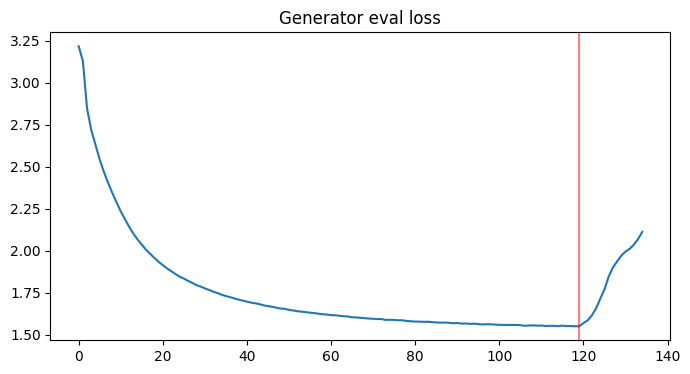

In [36]:
plt.plot(gen_pretrain_eval_loss + gen_adversarial_eval_loss)
plt.axvline(x=len(gen_pretrain_eval_loss)-1, color='r', alpha=.5)
plt.title('Generator eval loss');

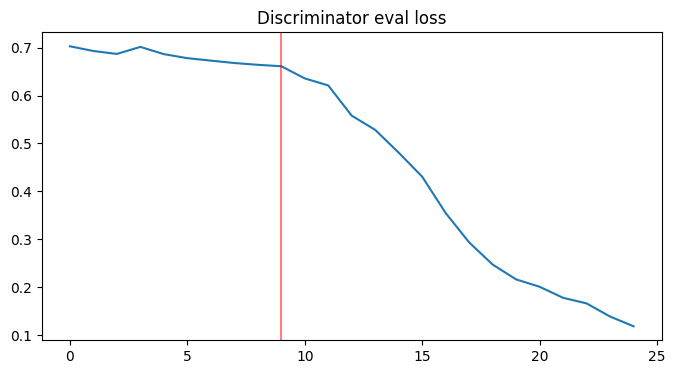

In [37]:
plt.plot(dis_pretrain_eval_loss + dis_adversarial_eval_loss)
plt.axvline(x=len(dis_pretrain_eval_loss)-1, color='r', alpha=.5)
plt.title('Discriminator eval loss');

Кривая функции потерь генератора здорового человека

<img src="https://raw.githubusercontent.com/sswt/dive2gai/main/.github/images/w4/seqgan_loss.png" alt="SeqGAN" width="60%" />

Это картинка из статьи, возможно дело в том, что там была другая постановка задачи - в качестве истинных последовательностей использовались сгенерированные "оракулом" (oracle) - случайным образом инициализированной LSTM-сетью.

Был ещё эксперимент по генерации подписей к изображениям из датасета [COCO Image Captions Dataset]() на основе готовой реализации из репозитория [TextGAN-PyTorch](https://github.com/williamSYSU/TextGAN-PyTorch). Он показал, что лосс на реальных последовательностях тоже не падает для генератора, он падает только для сгенерированных. На настоящих данных он немного растёт, но не так сильно, как в ноутбуке и визуально на качестве генерации текстов это не сказывается.

```
Pretrained by MLE:

BLEU-[2, 3, 4, 5] = [0.736, 0.505, 0.315, 0.195], NLL_gen = 0.7995, NLL_div = 0.8425, Self-BLEU-[2, 3, 4] = [0.902, 0.748, 0.554]

Generated: an airplane is flying low in the sky .

Adversarial training (epoch 0):

BLEU-[2, 3, 4, 5] = [0.725, 0.49, 0.305, 0.182], NLL_gen = 0.7989, NLL_div = 0.8195, Self-BLEU-[2, 3, 4] = [0.919, 0.771, 0.578]

Generated:  a white with an airport plane on the dashboard of a runway .

Adversarial training (epoch 99):

BLEU-[2, 3, 4, 5] = [0.771, 0.532, 0.313, 0.197], NLL_gen = 0.9851, NLL_div = 0.5379, Self-BLEU-[2, 3, 4] = [0.951, 0.871, 0.753]

Generated: a white toilet with a trash can .
```


Скрипт TextGAN адаптированный под текущий датасет находится [здесь](https://github.com/sswt/dive2gai/blob/main/unit4/seqgan_textgan.py), там проблему с немного растущим лоссом тоже решить не удалось.

## Упражнения

* попробуйте поменять параметры обучения
  * batch_size
  * число шагов и эпох обучения дискриминатора, генератора
  * другие параметры
* заставьте состязательное обучение работать 😸